# Planetary transit

In [3]:
from spice.models.binary import Binary, add_orbit, evaluate_orbit_at_times, evaluate_orbit
from spice.models.mesh_model import IcosphereModel
from spice.models.mesh_view import get_mesh_view
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from spice.spectrum import simulate_observed_flux
from transformer_payne import Blackbody
import jax.numpy as jnp
%matplotlib inline

A binary system can be instantiated with creating two separate mesh models. No position transformation needs to be applied - the Keplerian orbit is then calculated and bodies are moved in corresponding timesteps.

To apply the necessary transformation:
1. ```add_orbit``` needs to be called to add the orbit information
2. ```evaluate_orbit``` or ```evaluate_orbit_at_times``` (for multiple timesteps) needs to be called - the bodies are modified with the parameters calculated for a Keplerian orbit here.

The timestamps (```times```) are chosen so that the occlusion is captured.

In [4]:
import astropy.units as u

def default_icosphere(mass = 0.2, radius = 1.0, teff = 3000.):
    return get_mesh_view(IcosphereModel.construct(500, radius, mass, [teff], ['teff']), jnp.array([0., 1., 0.]))

body1 = default_icosphere()
body2 = default_icosphere(mass=0.1, radius=0.2, teff=2000.)
binary = Binary.from_bodies(body1, body2)

binary = add_orbit(binary, P=1.0, ecc=0., T=0., i=0., omega=0., Omega=0., mean_anomaly=0., reference_time=0., vgamma=0., orbit_resolution_points=25)
times = jnp.linspace(0.24, 0.26, 25)
pb1, pb2 = evaluate_orbit_at_times(binary, times)

/home/100/mj8805/scr/mj8805/miniconda3/envs/astro/lib/python3.12/site-packages/spice/models/mesh_model.py:245: UserWarning: If override_log_g is True, either parameter_names must include one of [logg,loggs,log_g,log_gs,log g,log gs,surface gravity,surface gravities,surface_gravity,surface_gravities], or log_g_index must be passed for log g to be used in the spectrum emulator.
  warnings.warn(f"If override_log_g is True, either parameter_names must include one of [" + ",".join(


Using search radius factor for KD-tree: 3.6133409


Let's use the simplest blackbody model for speed.

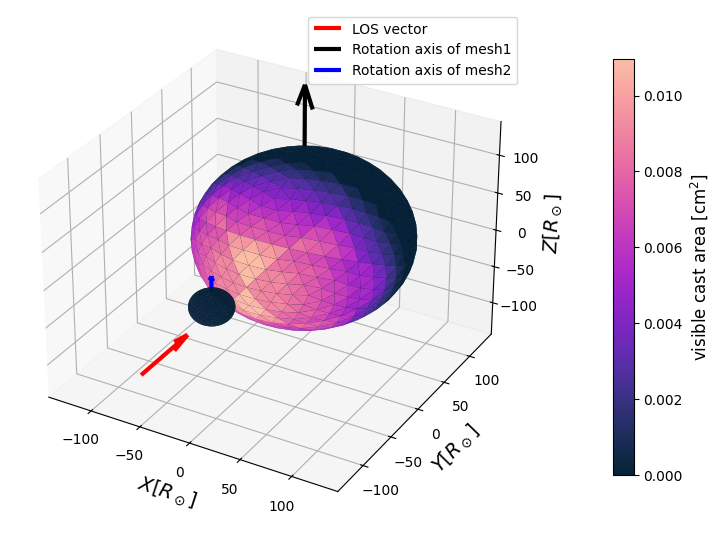

In [5]:
from spice.plots.plot_mesh import plot_3D_binary

i = 0
plot_3D_binary(pb1[i], pb2[i], property='visible_cast_areas', scale_radius=100);

MovieWriter ffmpeg unavailable; using Pillow instead.
/home/100/mj8805/scr/mj8805/miniconda3/envs/astro/lib/python3.12/site-packages/spice/plots/plot_mesh.py:481: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  animation.save(filename)
/home/100/mj8805/.local/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/100/mj8805/.local/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


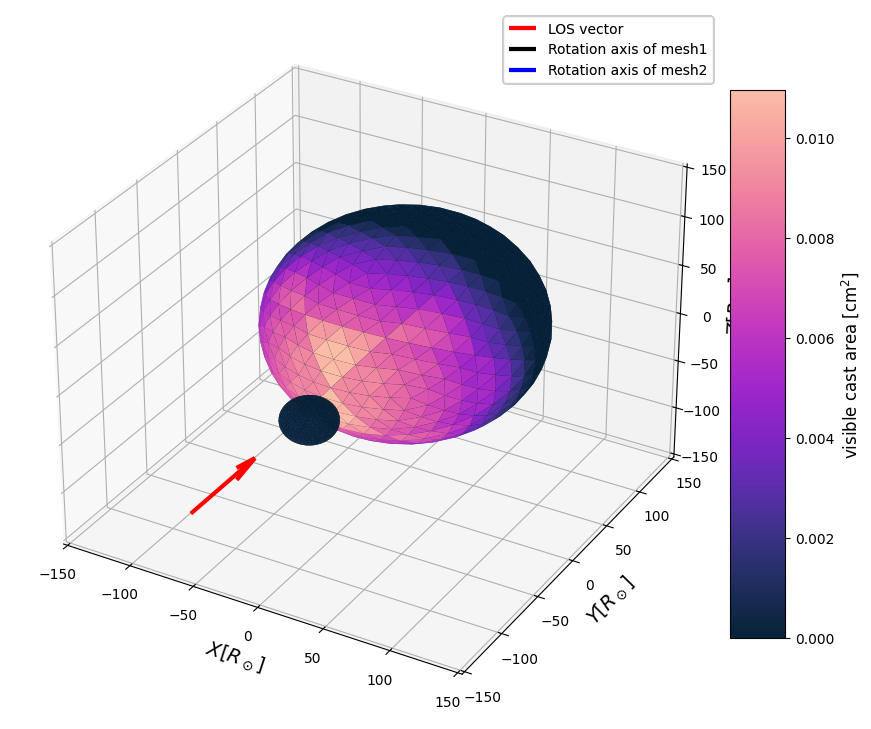

In [9]:
from spice.plots import animate_binary
animate_binary(pb1, pb2, property='visible_cast_areas', scale_radius=100, filename='planetary_transit.gif');

Let's evaluate the orbit to create arrays of meshes with calculated parameters.

## Synthetic photometry

Let's calculate the observed flux (for the default value of $d=10$ pc) for both components. To obtain the result flux, we need to sum the both parameters.

In [6]:
from tqdm import tqdm

bb = Blackbody()
ws = np.linspace(900, 40000, 1000)
s1s = [simulate_observed_flux(bb.intensity, _pb1, np.log10(ws)) for _pb1 in tqdm(pb1)]
s2s = [simulate_observed_flux(bb.intensity, _pb2, np.log10(ws)) for _pb2 in tqdm(pb2)]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 38.03it/s]


In [7]:
from spice.spectrum import AB_passband_luminosity
from spice.spectrum.filter import JohnsonCousinsV, GaiaG, Bolometric

johnsonV = JohnsonCousinsV()
lums_johnson_v = [AB_passband_luminosity(johnsonV, ws, s1[:, 0]+s2[:, 0]) for s1, s2 in zip(s1s, s2s)]
gaia_g = GaiaG()
lums_gaia_g = [AB_passband_luminosity(gaia_g, ws, s1[:, 0]+s2[:, 0]) for s1, s2 in zip(s1s, s2s)]
bolometric = Bolometric()
lums_bolometric = [AB_passband_luminosity(bolometric, ws, s1[:, 0]+s2[:, 0]) for s1, s2 in zip(s1s, s2s)]

And the corresponding lightcurves:

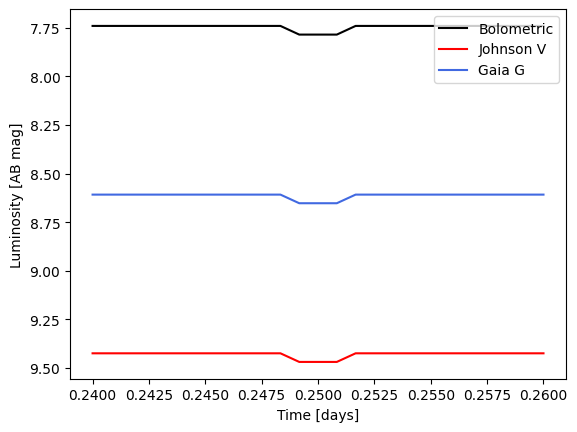

In [8]:
plt.plot(times, lums_bolometric, color='black', label='Bolometric')
plt.plot(times, lums_johnson_v, color='red', label='Johnson V')
plt.plot(times, lums_gaia_g, color='royalblue', label='Gaia G')
plt.gca().invert_yaxis()
plt.legend()
plt.gca().set_xlabel('Time [days]')
plt.gca().set_ylabel('Luminosity [AB mag]')
plt.show()